### In this notebook I'm figuring out how to pull down data from the dynamodb Alex is dumping data into from SF Open Data.
### I also do some basic inspection for insights.

In [13]:
import boto3
import json
from config import access_key, secret_access_key
from boto3.dynamodb.conditions import Key, Attr

import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
session = boto3.Session(
    aws_access_key_id=access_key,
    aws_secret_access_key=secret_access_key,
    region_name='us-west-2'
)

In [4]:
dynamodb = session.resource('dynamodb')

In [5]:
table = dynamodb.Table('BikeLaneReports')

In [6]:
print(table.creation_date_time)

2018-07-19 18:58:05.346000-07:00


Let's look at just district 3

In [7]:
response = table.scan(
    FilterExpression=Attr('supervisor_district').lt('3')
)
items = response['Items']

In [8]:
response.keys()

dict_keys(['Items', 'Count', 'ScannedCount', 'ResponseMetadata'])

In [9]:
len(items)

23

In [10]:
items[0]

{'address': '2198 OAKDALE AVE, SAN FRANCISCO, CA, 94124',
 'agency_responsible': 'Parking Enforcement Review Queue',
 'closed_date': '2018-07-05T13:58:19.000',
 'image_parsed': False,
 'lat': '37.74072',
 'long': '-122.4011',
 'media_url': 'http://mobile311.sfgov.org/media/san_francisco/report/photos/5b3e865352465b25131793ec/report.jpg',
 'neighborhoods_sffind_boundaries': 'Produce Market',
 'point': {'coordinates': [Decimal('-122.40121375'), Decimal('37.74092019')],
  'type': 'Point'},
 'police_district': 'BAYVIEW',
 'requested_datetime': '2018-07-05T13:58:16.000',
 's3_media_url': 'https://s3-us-west-1.amazonaws.com/lane-breach/311-sf/images/9228341.png',
 'service_details': 'Parking Enforcement',
 'service_name': 'Parking Enforcement',
 'service_request_id': '9228341',
 'service_subtype': 'Blocking_Bicycle_Lane',
 'source': 'Mobile/Open311',
 'status_description': 'Closed',
 'status_notes': 'The report has been logged and will help the City collect data on double parking and bike la

Actually, this data is quite small. Let's just pull it all down, json --> dataframe, and explore in pandas

In [11]:
response = table.scan()
items = response['Items']

In [12]:
len(items)

298

In [15]:
reports = pd.DataFrame.from_dict(items)

In [16]:
reports.columns

Index(['address', 'agency_responsible', 'closed_date', 'image_parsed', 'lat',
       'long', 'media_url', 'neighborhoods_sffind_boundaries', 'point',
       'police_district', 'requested_datetime', 's3_media_url',
       'service_details', 'service_name', 'service_request_id',
       'service_subtype', 'source', 'status_description', 'status_notes',
       'supervisor_district', 'updated_datetime'],
      dtype='object')

### Ok this isn't complete, we just have July 3 through 24 right now. 
- I think "closed_date" must just be "reported date"?

In [18]:
reports['closed_date'].min(), reports['closed_date'].max()

('2018-07-03T07:47:26.000', '2018-07-24T12:23:03.000')

In [19]:
reports['datestr'] = reports['closed_date'].apply(lambda t: t.split('T')[0])
reports['date'] = reports['datestr'].apply(lambda t: datetime.datetime.strptime(t, '%Y-%m-%d'))
reports['time'] = reports['closed_date'].apply(lambda t: t.split('T')[1].split('.')[0])
reports['hour'] = reports['time'].apply(lambda t: int(t.split(':')[0]))

Hacky cleaning up of address to get street name most of the time    

In [22]:
def getst(addr):
    weird_ones = ['EMBARCADERO','Rainbow Falls','GOODLETT']
    for w in weird_ones:
        if w in addr:
            return w
    st_types = [' ST',' BLVD',' AVE',' RD',' PL', ' DR']
    for t in st_types:
        addr = addr.split(t)[0]
    return addr.split(' ')[-1]

In [23]:
reports['street'] = reports['address'].apply(getst)

In [24]:
set(reports['street'])

{'11TH',
 '14TH',
 '17TH',
 '1ST',
 '25TH',
 '37TH',
 '6TH',
 '7TH',
 '8TH',
 'ALEMANY',
 'ARGUELLO',
 'BAKER',
 'BASIN',
 'BAY',
 'BEALE',
 'BUCHANAN',
 'CHAVEZ',
 'DIVISION',
 'EMBARCADERO',
 'EUCLID',
 'FOLSOM',
 'FULTON',
 'GATE',
 'GOODLETT',
 'GRACE',
 'GROVE',
 'HOWARD',
 'JERROLD',
 'JESSIE',
 'JOSE',
 'KING',
 'KIRKHAM',
 'MARKET',
 'MASONIC',
 'MISSION',
 'MOSS',
 'NESS',
 'OAK',
 'OAKDALE',
 'POLK',
 'PORTOLA',
 'POTRERO',
 'Rainbow Falls',
 'SLOAT',
 'SPARROW',
 'TOWNSEND',
 'VALENCIA',
 'WEBSTER'}

### Let's find how many reports there are by street, by district, by both, etc
  

In [25]:
def numreportsby(key):
    return (reports.groupby([key])
                  .count()['address']
                  .reset_index()
                  .rename(columns = {'address':'num_reports'})
                  .sort_values('num_reports', ascending=False)
                  .reset_index(drop=True)
           )

In [26]:
num_reports_street = numreportsby('street')
num_reports_street.head(10)

,street,num_reports
0,FOLSOM,70
1,VALENCIA,39
2,HOWARD,29
3,MARKET,24
4,EMBARCADERO,20
5,FULTON,10
6,11TH,8
7,17TH,8
8,OAKDALE,6
9,7TH,6


In [27]:
num_reports_supe = numreportsby('supervisor_district')
num_reports_supe

,supervisor_district,num_reports
0,6,127
1,9,51
2,8,44
3,5,31
4,3,18
5,10,17
6,1,3
7,2,3
8,7,3
9,4,1


### Here I'm finding the 2 worst streets for every supervisor. 
- We could tweet to the supe, Hey! Folsom is your worst street -- it's been reported 39 times in X days!

In [28]:
supestreet = (reports.groupby(['supervisor_district','street'])
                  .count()['address']
                  .reset_index()
                  .rename(columns = {'address':'num_reports'})
                  .sort_values('num_reports', ascending=False)
                  .reset_index(drop=True)
          )
supestreet['supervisor_district'] = supestreet['supervisor_district'].astype(int)
top2_per_supe = (supestreet.groupby('supervisor_district')
                           .head(2)
                           .sort_values(['supervisor_district','num_reports'],
                                        ascending=(True, False))
                           .reset_index(drop=True)
                )
top2_per_supe

,supervisor_district,street,num_reports
0,1,ARGUELLO,2
1,1,Rainbow Falls,1
2,2,EUCLID,1
3,2,BAY,1
4,3,EMBARCADERO,15
5,3,POLK,2
6,4,37TH,1
7,5,FULTON,10
8,5,MARKET,4
9,6,FOLSOM,39


### What about the temporal nature? 
- Can we use that to recommend patrolling at certain times of day?  
- Or parking laws by time of day?

In [29]:
folsom_overtime = reports.loc[reports['street']=='FOLSOM'].sort_values('closed_date')

### For the 3 most-reported streets, how does it look by hour?
- Not surprisingly, Folsom and Howard switch off morning and afternoon because of rush hour and being one way
- Valencia gets many more reports in the evening though! Apparently TNCs are even worse than deliveries.
- Could be interesting to look by weekend / weekday

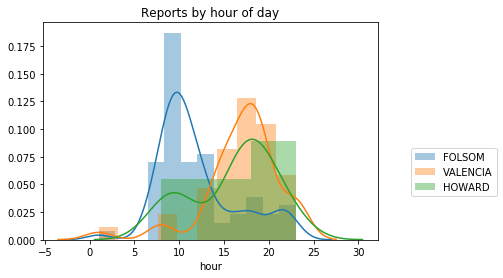

In [30]:
for st in num_reports_street.head(3)['street']:
    bystreet = reports.loc[reports['street']==st].sort_values('closed_date')
    sns.distplot(bystreet['hour'], label=st, kde=True, norm_hist=False);
plt.legend(loc=[1.1,.2]);
plt.title('Reports by hour of day');

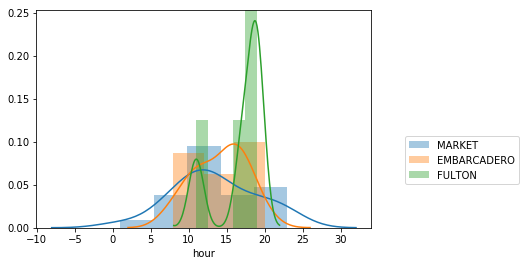

In [31]:
for st in num_reports_street.iloc[3:6]['street']:
    bystreet = reports.loc[reports['street']==st].sort_values('closed_date')
    sns.distplot(bystreet['hour'], label=st, kde=True, norm_hist=False);
plt.legend(loc=[1.1,.2]);

### How are they changing over days of the month?  
- I don't think we have enough data to say anything, statistically.
- But we could say "Folsom had its worse day today!" whenever that is true

In [34]:
st = 'FOLSOM'
bystreet = reports.loc[reports['street']==st].sort_values('closed_date')
# sns.tsplot(data=bystreet, x='date', )

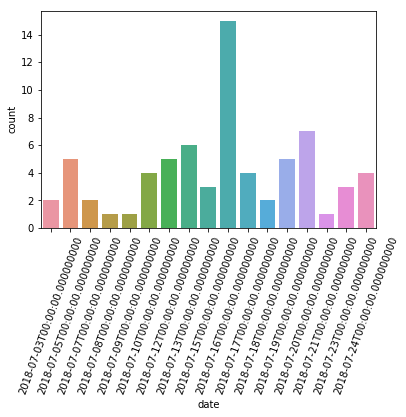

In [35]:
sns.countplot(data=bystreet, x='date');
plt.xticks(rotation=70);

/Users/erinboyle/python/virtualenv/python3-env/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


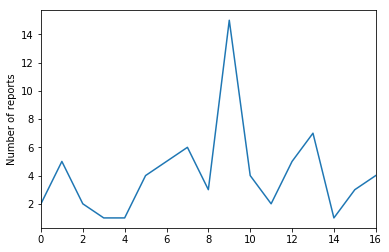

In [36]:
grpd = bystreet.groupby('date').count()['hour']
sns.tsplot(data=grpd, value='hour');
plt.ylabel('Number of reports');